In [4]:
import numpy as np

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size


    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for i in range(5):
        x, y = landmarks[2 * i], landmarks[2 * i + 1]
        hm = create_heatmap(image_shape, (x, y), sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import os


class Paths:
    table_csv = '/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv'
    root_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'


class FaceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file).iloc[:1000]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        landmarks = self.annotations.iloc[idx, 1:].values.astype('float16')

        if self.transform:
            image = self.transform(image)

        heatmaps = landmarks_to_heatmaps(image.shape[1:], landmarks)

        return image, heatmaps
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


path = Paths()

data = FaceDataset(path.table_csv, path.root_dir, transform=transform)

In [6]:
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)
    

class Hourglass(nn.Module):
    def __init__(self, depth, num_features):
        super().__init__()
        self.depth = depth
        self.num_features = num_features
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.upper_branch = nn.ModuleList([ResidualBlock(num_features, num_features) for _ in range(depth)])
        self.lower_branch = nn.ModuleList([ResidualBlock(num_features, num_features) for _ in range(depth)])
        self.skip_branch = nn.ModuleList([ResidualBlock(num_features, num_features) for _ in range(depth)])

    def forward(self, x, level=0):
        if level == self.depth - 1:
            return self.lower_branch[level](x)

        up1 = self.upper_branch[level](x)
        low1 = self.downsample(up1)
        low2 = self.forward(low1, level + 1)
        low3 = self.lower_branch[level](low2)
        up2 = self.upsample(low3)

        skip = self.skip_branch[level](x)
        return up2 + skip
    

class StackedHourglass(nn.Module):
    def __init__(self, num_stacks=2, num_features=256, num_keypoints=10):
        super().__init__()
        self.num_stacks = num_stacks
        self.num_features = num_features

        self.conv1 = nn.Conv2d(3, num_features // 2, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features // 2)
        self.relu = nn.ReLU(inplace=True)
        self.res1 = ResidualBlock(num_features // 2, num_features)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.hourglasses = nn.ModuleList([Hourglass(depth=4, num_features=num_features) for _ in range(num_stacks)])
        self.residuals = nn.ModuleList([ResidualBlock(num_features, num_features) for _ in range(num_stacks)])
        self.out_convs = nn.ModuleList([nn.Conv2d(num_features, num_keypoints, kernel_size=1) for _ in range(num_stacks)])
        self.heatmap_convs = nn.ModuleList([nn.Conv2d(num_keypoints, num_features, kernel_size=1) for _ in range(num_stacks - 1)])
        self.intermediate_convs = nn.ModuleList([nn.Conv2d(num_features, num_features, kernel_size=1) for _ in range(num_stacks - 1)])
        self.intermediate_residuals = nn.ModuleList([ResidualBlock(num_features, num_features) for _ in range(num_stacks - 1)])

    def forward(self, x):
        outputs = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.res1(x)
        x = self.pool(x)

        for i in range(self.num_stacks):
            hg = self.hourglasses[i](x)
            res = self.residuals[i](hg)
            out = self.out_convs[i](res)
            outputs.append(out)

            if i < self.num_stacks - 1:
                out_transformed = self.heatmap_convs[i](out)
                x = x + self.intermediate_convs[i](res) + out_transformed
                x = self.intermediate_residuals[i](x)

        return outputs


In [7]:
import pytorch_lightning as pl
import torch.optim as optim

class FaceLandmarksModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = StackedHourglass(2, num_features=256, num_keypoints=5)
        self.criterion = nn.MSELoss()
        

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        total_loss += loss.item()
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [8]:
from torch.utils.data import random_split, DataLoader

BATCH_SIZE = 8

train_ds, val_ds = random_split(data, [800, 200])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [9]:
model_pl = FaceLandmarksModel()

trainer = pl.Trainer(max_epochs=20, logger=True)
trainer.fit(model_pl, train_dl, val_dl)

2025-06-19 10:11:07.658589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750327867.684105     241 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750327867.691899     241 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


AttributeError: 'list' object has no attribute 'size'

------------------------------------------

In [9]:
import torch.optim as optim
import torch


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = StackedHourglass(2, num_features=256, num_keypoints=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np


plt.figure(figsize=(15, 10))

def show_graphics(train_loss, val_loss):
    clear_output()

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss)), train_loss)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(val_loss)), val_loss)
    plt.yscale('log')
    plt.grid()


    plt.show()

<Figure size 1500x1000 with 0 Axes>

In [6]:
def run(model, dataloader, criterion, optimizer, train_mode=False):
    model.train() if train_mode else model.eval()

    total_loss = 0.0
    count = 0

    for img, heatmap in dataloader:
        if img is None or heatmap is None:
            continue

        img = img.to(device).float()
        heatmap = heatmap.to(device).float()

        with torch.set_grad_enabled(train_mode):
            outputs = model(img)
            loss = 0.0

            for out in outputs:
                resized_heatmap = nn.functional.interpolate(
                    heatmap, size=out.shape[2:], mode='bilinear', align_corners=False
                )
                loss += criterion(out, resized_heatmap)

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        count += 1

        del img, heatmap, outputs, loss
        torch.cuda.empty_cache()

    return total_loss / count if count > 0 else 0


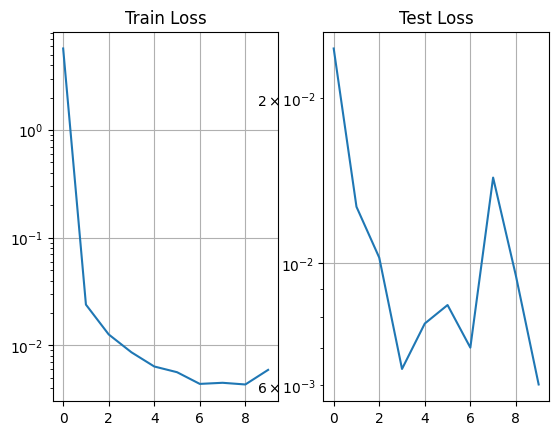

In [10]:
from torch.utils.data import DataLoader, random_split
import torch
import gc

NUM_EPOCH = 10
BATCH_SIZE = 4

train_data, val_data = random_split(data, (0.8, 0.2))
train_dataloader = DataLoader(train_data, BATCH_SIZE)
val_dataloader = DataLoader(val_data, BATCH_SIZE)

train_loss, val_loss = [], []

for epoch in range(NUM_EPOCH):

    train_loss_epoch = run(model, train_dataloader, criterion, optimizer, True)
    train_loss.append(train_loss_epoch)
    torch.cuda.empty_cache()
    gc.collect()    

    val_loss_epoch = run(model, val_dataloader, criterion, optimizer)
    val_loss.append(val_loss_epoch)
    torch.cuda.empty_cache()
    gc.collect()

    show_graphics(train_loss, val_loss)
    


In [12]:
torch.save(model.state_dict(), 'model_hourglass_10epoch.pt')

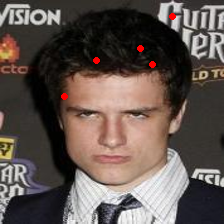

In [58]:
from PIL import Image, ImageDraw
photo = Image.open('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000091.jpg').convert('RGB').resize((224, 224))

photo4model = transform(photo).to(device).unsqueeze(0)
with torch.no_grad():
    output = model(photo4model)

draw = ImageDraw.Draw(photo)

heatmaps = output[0].squeeze(0).cpu().numpy()
keypoints = []

for hm in heatmaps:
    y, x = np.unravel_index(np.argmax(hm), hm.shape)

    x = int(x * (224 / 56))
    y = int(y * (224 / 56))
    keypoints.append((x, y))

draw = ImageDraw.Draw(photo)
for x, y in keypoints:
    r = 3
    draw.ellipse((x - r, y - r, x + r, y + r), fill='red')

photo